In [1]:
import argparse
import cv2
import os
import easygui
import pandas as pd
from matplotlib import pyplot as plt

# import the necessary packages
import argparse
import cv2
import os
import easygui
import pandas as pd
from matplotlib import pyplot as plt

class CropLayer(object):
    def __init__(self, params, blobs):
        # initialize our starting and ending (x, y)-coordinates of
        # the crop
        self.startX = 0
        self.startY = 0
        self.endX = 0
        self.endY = 0

    def getMemoryShapes(self, inputs):
        # the crop layer will receive two inputs -- we need to crop
        # the first input blob to match the shape of the second one,
        # keeping the batch size and number of channels
        (inputShape, targetShape) = (inputs[0], inputs[1])
        (batchSize, numChannels) = (inputShape[0], inputShape[1])
        (H, W) = (targetShape[2], targetShape[3])

        # compute the starting and ending crop coordinates
        self.startX = int((inputShape[3] - targetShape[3]) / 2)
        self.startY = int((inputShape[2] - targetShape[2]) / 2)
        self.endX = self.startX + W
        self.endY = self.startY + H

        # return the shape of the volume (we'll perform the actual
        # crop during the forward pass
        return [[batchSize, numChannels, H, W]]

    def forward(self, inputs):
        # use the derived (x, y)-coordinates to perform the crop
        return [inputs[0][:, :, self.startY:self.endY,
                self.startX:self.endX]]

# load our serialized edge detector from disk
print("[INFO] loading edge detector...")

fpath = os.path.abspath('./jupyter')
fdir =  os.path.dirname(fpath)
print(fdir)
protoPath = os.path.sep.join([fdir,"hed", "deploy.prototxt"])
print(protoPath)
modelPath =  os.path.sep.join([fdir,"hed","hed_bsds.caffemodel"])
print(modelPath)

net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

# register our new layer with the model
cv2.dnn_registerLayer("Crop", CropLayer)

[INFO] loading edge detector...
/home/dstark1977_gmail_com/repo/jupyter
/home/dstark1977_gmail_com/repo/jupyter/hed/deploy.prototxt
/home/dstark1977_gmail_com/repo/jupyter/hed/hed_bsds.caffemodel


[INFO] performing Canny edge detection...
[[[[ 51.  47.  45. ... -61. -60. -65.]
   [ 51.  49.  47. ... -61. -62. -62.]
   [ 53.  53.  50. ... -61. -62. -64.]
   ...
   [  1.   2.   5. ...  12.  13.  15.]
   [  6.   1.   6. ...  13.  13.  12.]
   [  1.   2.   7. ...  12.  14.  21.]]

  [[ 56.  55.  53. ... -39. -39. -42.]
   [ 56.  55.  55. ... -40. -41. -40.]
   [ 58.  58.  57. ... -39. -39. -43.]
   ...
   [ 32.  34.  35. ...  37.  38.  40.]
   [ 37.  36.  35. ...  38.  35.  36.]
   [ 37.  37.  38. ...  36.  41.  39.]]

  [[103. 100.  98. ...  10.  10.   2.]
   [103. 101. 100. ...   9.   8.   8.]
   [105. 104. 102. ...   9.   9.   7.]
   ...
   [ 85.  87.  89. ...  89.  90.  91.]
   [ 84.  83.  88. ...  89.  88.  87.]
   [ 79.  80.  91. ...  81.  81.  85.]]]]
[INFO] performing holistically-nested edge detection...


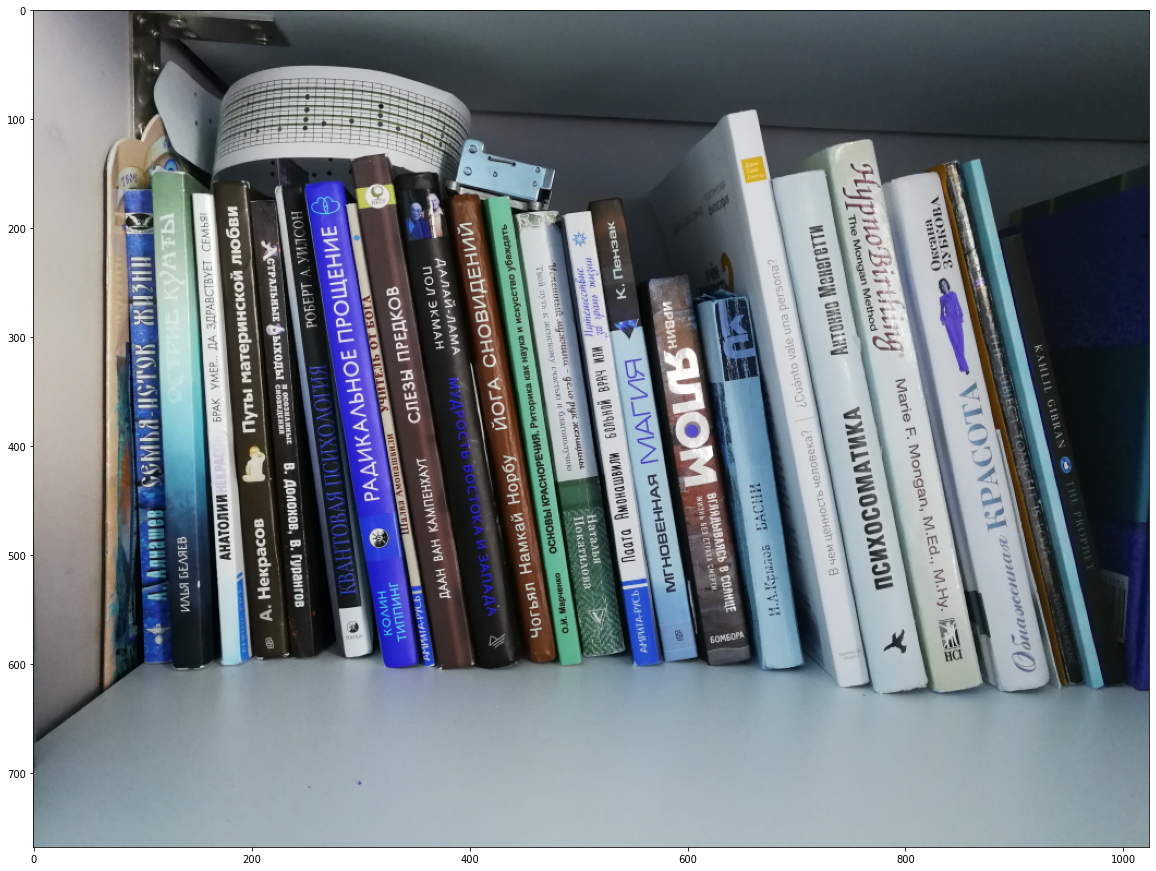

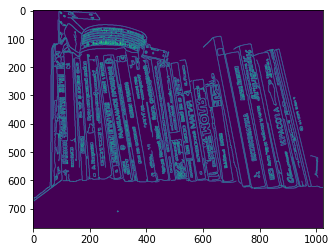

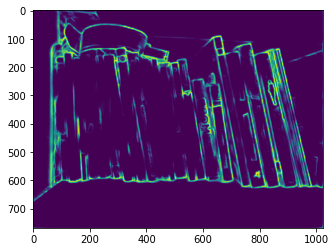

In [2]:
# load the input image and grab its dimensions
image = cv2.imread('sample.jpg')

# resize image
scale_percent = 20 # percent of original size
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)
image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

# image =cv2.equalizeHist(img)
# image = cv2.pyrMeanShiftFiltering(image1,10,20)
(H, W) = image.shape[:2]
# print(image.shape[:2])
# image.shape[:2] =(H*3, W*3)ho

# convert the image to grayscale, blur it, and perform Canny
# edge detection
print("[INFO] performing Canny edge detection...")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# blurred = cv2.addWeighted(gray,1.5,blurred,-0.5,0)
canny = cv2.Canny(blurred,30, 150)


# construct a blob out of the input image for the Holistically-Nested
# Edge Detector

# cc = cv2.cvtColor(canny, cv2.COLOR_GRAY2BGR)
# image = image+cc

# mean = (104.00698793, 116.66876762, 122.67891434),

blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(W, H),
                             # mean=(110,95,95),
                             # mean=(104.00698793, 116.66876762, 122.67891434),
                            # mean=(104, 116, 122),
                             mean=(130, 120, 75),
                            #  mean=(145, 147, 180),
                             swapRB= False, crop=False)
print( blob)
cv2.waitKey(0)
# set the blob as the input to the network and perform a forward pass
# to compute the edges
print("[INFO] performing holistically-nested edge detection...")
net.setInput(blob)
hed = net.forward()
hed = cv2.resize(hed[0, 0], (W, H))
hed = (255 * hed).astype("uint8")
# show the output edge detection results for Canny and
# Holistically-Nested Edge Detection
plt.figure(figsize = (20,20))
plt.imshow(image)
plt.show()
plt.imshow(canny)
plt.show()
plt.imshow(hed)
plt.show()

#plt.imwrite(hout, hed)
#plt.waitKey(0)

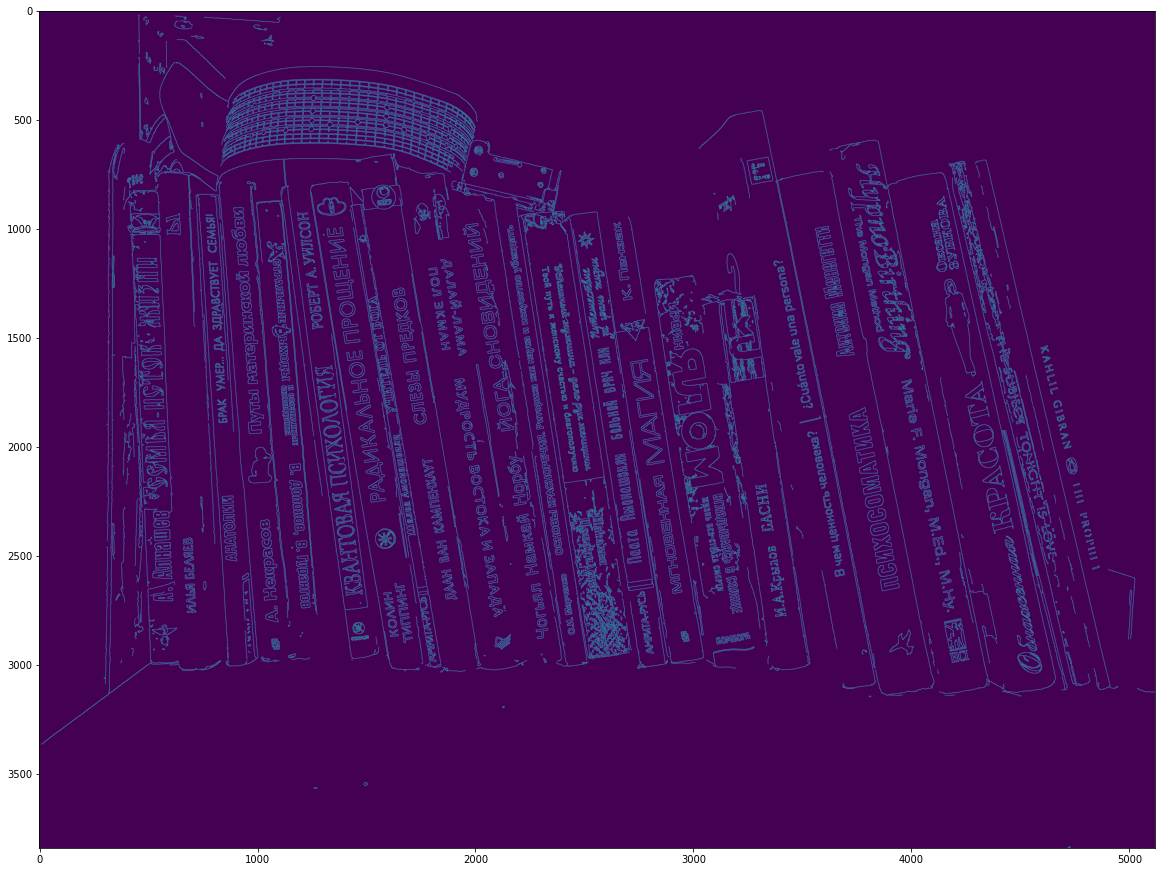

In [2]:
import cv2
import numpy as np
from google.cloud import storage
import json
from matplotlib import pyplot as plt

def imread_blob(blob):
    img = cv2.imdecode(np.asarray(bytearray(blob.download_as_string()), dtype=np.uint8), cv2.IMREAD_COLOR)
    return img

client = storage.Client()
bucket = client.get_bucket('biblosphere-210106.appspot.com')

user = '0000000000000000000000000000'
shelf = '0000000000033'

#user = 'AWsv5n9QiJYIUcDQmxWlBKRoBzZ2'
#shelf = '1590618924998' # '1590619142574', '1590619327951'
#shelf = '1590619142574' # '1590619327951'
#shelf = '1590619327951'

image_blob = bucket.blob('images/%s/%s.jpg' % (user, shelf))
result_blob = bucket.blob('images/%s/%s.json' % (user, shelf))

img = imread_blob(image_blob)
results = json.loads(result_blob.download_as_string())
#for b in results['recognized']:
#    cv2.drawContours(img, np.array([b['outline']]), 0, (0, 255, 0), 7)
#for b in results['unrecognized']:
#    cv2.drawContours(img, np.array([b['outline']]), 0, (0, 0, 255), 7)


gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# blurred = cv2.addWeighted(gray,1.5,blurred,-0.5,0)
canny = cv2.Canny(blurred, 30, 150)

plt.figure(figsize = (20,20))
plt.imshow(canny)

uint8
SIZE: 194 3858
INPUT: -1291 1291 -72 71
RESULT: -1628 2230 -91 102


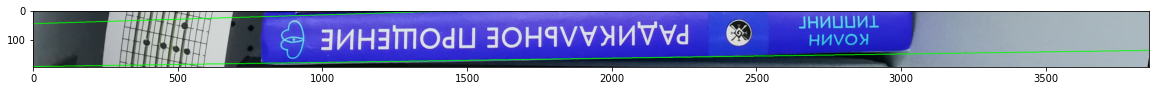

In [109]:
# Calculate angle of the line
def line_angle(A, B, full=False):
    side = A - B
    if side[0] == 0:
        if side[1] > 0:
            angle = np.pi / 2
        else:
            angle = -np.pi / 2

    else:
        angle = np.arctan(side[1] / side[0])

    if full:
        if side[0] < 0:
            if angle <= 0:
                angle += np.pi
            elif angle > 0:
                angle -= np.pi

    return angle

# Calculate length and angle for a box
def box_angle(b, longside = True):
    # Incline of longer side
    if longside and np.sum((b[1]-b[0])**2) < np.sum((b[2]-b[1])**2):
        b = np.roll(b, 1, axis=0)

    #length = max(np.sqrt(np.sum((b[1]-b[0])**2)), np.sqrt(np.sum((b[2]-b[1])**2)))
    angle = line_angle(b[0], b[1])

    if not longside:
        if angle > np.pi/4:
            angle -= np.pi/2
        elif angle < -np.pi/4:
            angle += np.pi/2

    return angle

def rotate_rect(img, contour, trace=False):
    theta = box_angle(np.reshape(contour, (4,2)))

    # rotate img
    if theta > np.pi * 0.5:
        theta = theta - np.pi

    x, y, w, h = cv2.boundingRect(contour)

    maxY, maxX = img.shape[:2]
    marginX, marginY = 0, 0 #np.int0(0.1 * w), np.int0(0.1 * h)

    w, h = w + 2 * marginX, h + 2 * marginY
    x, y = x - marginX, y - marginY

    if x < 0:
        w, x = w - x, 0

    if y < 0:
        h, y = h - y, 0

    if x + w >= maxX:
        w = maxX - x - 1

    if y + h >= maxY:
        h = maxY - y - 1

    rx = w // 2
    ry = h // 2

    # crop source
    d1 = np.array([x, y])
    img_crop = img[y:y + h, x:x + w]
    contour[:, :, 0] = contour[:, :, 0] - x
    contour[:, :, 1] = contour[:, :, 1] - y

    if trace:
        print('Image before rotation: ', img_crop.shape)
        #plot_img(img_crop, show=True)
        print('Contour before rotation: ', contour)
        print('Bounding rectangle: ', x, y, w, h)
        print('Rotation centre: ', rx, ry)

    # grab the rotation matrix
    M = cv2.getRotationMatrix2D((rx, ry), theta / np.pi * 180, 1)

    # grab the sine and cosine (i.e., the rotation components of the matrix)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - rx
    M[1, 2] += (nH / 2) - ry

    # rotate contour
    contour_rot = np.int0(cv2.transform(contour, M))[0]

    # Rotate image
    img_rot = cv2.warpAffine(img_crop, M, (nW, nH))

    if trace:
        print('Image after rotation: ', img_rot.shape)
        #plot_img(img_rot, show=True)

    # mask = np.zeros(img_rot.shape[0:2])
    # cv2.drawContours(mask, np.array([contour_rot]), -1, 255, -1)
    # img_masked = np.zeros_like(img_rot)
    # img_masked[mask == 255] = img_rot[mask == 255]

    # crop
    x, y, w, h = cv2.boundingRect(contour_rot)

    maxY, maxX = img_rot.shape[:2]
    marginX, marginY = 0, 0 #np.int0(0.2 * w), np.int0(0.05 * h)
    w, h = w + 2 * marginX, h + 2 * marginY
    x, y = x - marginX, y - marginY

    if x < 0:
        w, x = w - x, 0

    if y < 0:
        h, y = h - y, 0

    if x + w >= maxX:
        w = maxX - x - 1

    if y + h >= maxY:
        h = maxY - y - 1

    d2 = np.array([x, y])

    # img_crop = img_masked[y:y + h, x:x + w]
    img_crop = img_rot[y:y + h, x:x + w]
    if trace:
        print('Image cropped:', img_crop.shape)
        #plot_img(img_crop, show=True)

    return img_crop, M, d1, d2


# Rotate points around the center
def rotate_only(points, theta, trace=False):
    rx, ry = 0, 0

    if trace:
        print('Contour before rotation: ', points)

    # grab the rotation matrix
    M = cv2.getRotationMatrix2D((0, 0), theta / np.pi * 180, 1)

    # grab the sine and cosine (i.e., the rotation components of the matrix)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    #nW = int((h * sin) + (w * cos))
    #nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    #M[0, 2] += (nW / 2) - rx
    #M[1, 2] += (nH / 2) - ry

    # rotate contour
    contour_rot = np.int0(cv2.transform(points, M))

    if trace:
        print('Contour after rotation: ', contour_rot)

    return contour_rot

def spine_rectangle(contour):
    rect = cv2.minAreaRect(contour)
    return np.int0(cv2.boxPoints(rect))

def is_between(a, b, c):
    return (a[0] <= c[0] <= b[0] or b[0] <= c[0] <= a[0]) and (a[1] <= c[1] <= b[1] or b[1] <= c[1] <= a[1])


def extend_line(line, W):
    (x1, y1), (x2, y2) = line
    y_start = np.int0(y1 - x1 * (y2 - y1) / (x2 - x1))
    y_end = np.int0(y1 + (W - x1) * (y2 - y1) / (x2 - x1))
    return np.array([[0, y_start], [W, y_end]])

                
def horisontal_lines(image):
    canny = cv2.Canny(image, 30, 150)
    lines = cv2.HoughLinesP(canny, 1, 0.2 * np.pi/180, threshold = 100, minLineLength = 500, maxLineGap = 50)
    mask = canny
    
    if lines is None:
        print('Canny failed')
        kernel = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                           [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                           [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                           [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]], dtype=np.int8)

        horizontal = cv2.filter2D(image, cv2.CV_32F, kernel)
        horizontal = np.abs(horizontal)
        horizontal[horizontal>255] = 255
        horizontal = np.uint8(horizontal)

        _, threshold = cv2.threshold(horizontal, 0, 255 ,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        #kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
        #closed = cv2.morphologyEx(threshold, cv2.MORPH_CLOSE, kernel, iterations = 3)

        #kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
        #opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations = 3)

        thinned = cv2.ximgproc.thinning(threshold, thinningType = cv2.ximgproc.THINNING_ZHANGSUEN) #THINNING_GUOHALL

        mask = thinned
        
        #lines= cv2.HoughLines(thinned, 1, np.pi/180.0, 165, srn=0, stn=0, min_theta=0.97*np.pi/2, max_theta=1.03*np.pi/2)
        lines = cv2.HoughLinesP(thinned, 1, 0.2 * np.pi/180, threshold = 100, minLineLength = 500, maxLineGap = 100)
    
        if lines is None:
            lines = cv2.HoughLinesP(thinned, 1, np.pi/180, threshold = 50, minLineLength = 250, maxLineGap = 100)

    if lines is not None:
        for line in lines:
    #        #print(type(line), line.shape)
            cv2.line(mask, (line[0][0], line[0][1]), (line[0][2], line[0][3]), 255, 2)


    # Group close lines together
    # TODO: Take average instead of skip
    
    (H, W) = image.shape[:2]
    ext_lines = []
    for line in lines:
        #print(type(line), line.shape)
        for x1,y1,x2,y2 in line:
            if x2 != x1:
                ext_lines.append(extend_line(np.array([[x1,y1], [x2,y2]]), W-1))
                
    result_lines = []
    eps = 5 # Play with the value
    for l in ext_lines:
        to_be_added = True
        for r in result_lines:
            if abs(l[0][1] - r[0][1]) <= eps and abs(l[1][1] - r[1][1]) <= eps:
                to_be_added = False
                break
        if to_be_added:
            result_lines.append(l)
        
    #if result_lines is not None:
    #    for line in result_lines:
    #        #print(type(line), line.shape)
    #        cv2.line(mask, (line[0][0], line[0][1]), (line[1][0], line[1][1]), 255, 2)
    
    #print('LINES:', lines)
    
    result_lines.sort(key=lambda line:line[0][1])
    
    return result_lines, mask #canny #thinned #opened #threshold #horizontal #thinned
    
    
(H, W) = img.shape[:2]
results = json.loads(result_blob.download_as_string())
rects = np.array([spine_rectangle(np.array(b['outline'])) for b in results['recognized'] + results['unrecognized']])

rects = np.append(rects, [[[0, 0], [0, H], [W, H], [W, 0]]], axis = 0)
#print(rects.shape)

results = np.empty((0,4,2), dtype=np.int16)

for i in [15]: #range(rects.shape[0] - 1): 
    # 3 - text outside the text area
    # 3, 11 - inclined
    # 11 (bottom) - sharp only canny, not filter2D
    # 6 (bottom) - not a straight line
    # 6 (top) - "invisible" border
    # 7 (top) - difficult
    center = (rects[i,0] + rects[i,2]) // 2
    shifted = rects - center
    theta = box_angle(rects[i, :, :])
    rotated = rotate_only(shifted, theta)
    
    #print(rotated[i, :, :])
    #print(np.min(rotated[i, :, :], axis=0))
    #print(np.max(rotated[i, :, :], axis=0))
    
    l_min, h_min = np.min(rotated[i, :, :], axis=0)
    l_max, h_max = np.max(rotated[i, :, :], axis=0)
    
    # List of indexes to process
    indexes = np.ones((rects.shape[0],), dtype=int)
    indexes[i] = 0
    
    all_limits = np.empty((0,2), dtype=np.int16)
    #print('All limits:', all_limits.shape)
    
    # Loop through all sides and find the one which are limiting given box
    for j in range(rotated.shape[0]):
        # Skip the box itself
        if j == i:
            continue
            
        # Check if points are in the projection of the original box
        points = np.reshape(rotated[j, :, :], (-1, 2))
        #print(points.shape)

        # Check if each side is intersect with the projection of the box
        for k in range(4):
            # Find intersection of section to box projection
            a, b = points[k, :], points[(k+1) % 4, :]
            #print('Points: ', a, b)
            
            if b[0] == a[0]:
                candidates = [[a[0], h_min], [a[0], h_max]]
            elif b[1] == a[1]:
                candidates = [[l_min, a[1]], [l_max, a[1]]]
            else:
                candidates = [[l_min, a[1] + (l_min - a[0]) * (b[1] - a[1]) / (b[0] - a[0])],
                              [l_max, a[1] + (l_max - a[0]) * (b[1] - a[1]) / (b[0] - a[0])],
                              [a[0] + (h_min - a[1]) * (b[0] - a[0]) / (b[1] - a[1]), h_min],
                              [a[0] + (h_max - a[1]) * (b[0] - a[0]) / (b[1] - a[1]), h_max]]
            
            limits = [np.int0(p) for p in candidates if is_between(a,b,p)]
                  
            if len(limits) > 0:
                #print('Limits:', limits)
                #print('Limits shape:', np.array(limits).shape)
                all_limits = np.append(all_limits, np.array(limits), axis=0)
                #print('All limits:', all_limits.shape)
        
    #print('All limits:', all_limits)
    #print(indexes)
    #print(rotated.shape)
    #print(rotated[indexes==1, :, :].shape)

    #print(rotated[indexes==1, :, :])
    
    points = np.reshape(rotated[indexes==1, :, :], (-1, 2))
    #print(points.shape)
    
    left = np.all([points[:,0] < l_min, points[:,1] >= h_min, points[:,1] <= h_max], axis=0)
    right = np.all([points[:,0] > l_max, points[:,1] >= h_min, points[:,1] <= h_max], axis=0)
    top = np.all([points[:,1] < h_min, points[:,0] >= l_min, points[:,0] <= l_max], axis=0)
    bottom = np.all([points[:,1] > h_max, points[:,0] >= l_min, points[:,0] <= l_max], axis=0)
    
    if np.sum(left) > 0:
        all_limits = np.append(all_limits, points[left], axis=0)
        #print('All limits (add from left):', all_limits.shape)

    if np.sum(right) > 0:
        all_limits = np.append(all_limits, points[right], axis=0)
        #print('All limits (add from right):', all_limits.shape)

    if np.sum(top) > 0:
        all_limits = np.append(all_limits, points[top], axis=0)
        #print('All limits (add from top):', all_limits.shape)
                              
    if np.sum(bottom) > 0:
        all_limits = np.append(all_limits, points[bottom], axis=0)
        #print('All limits (add from bottom):', all_limits.shape)

    points = all_limits
                              
    left = np.max(points[np.all([points[:,0] <= l_min, points[:,1] >= h_min, points[:,1] <= h_max], axis=0), 0])
    right = np.min(points[np.all([points[:,0] >= l_max, points[:,1] >= h_min, points[:,1] <= h_max], axis=0), 0])
    top = np.max(points[np.all([points[:,1] <= h_min, points[:,0] >= l_min, points[:,0] <= l_max], axis=0), 1])
    bottom = np.min(points[np.all([points[:,1] >= h_max, points[:,0] >= l_min, points[:,0] <= l_max], axis=0), 1])
    
    result = np.array([[[left, top], [right, top], [right, bottom], [left, bottom]]])
    result_rotated = rotate_only(result, -theta)
    result_shifted = result_rotated + center
    results = np.append(results, result_shifted, axis=0)

    img_crop, M, d1, d2 = rotate_rect(img, result_shifted, trace=False)
    print(img_crop.dtype)

    # Convert to HSV use H - color for bright images and V for dark one
    #hsv = cv2.cvtColor(img_crop, cv2.COLOR_BGR2HSV)
    
    gray = cv2.cvtColor(img_crop,cv2.COLOR_BGR2GRAY)
    blurred = cv2.bilateralFilter(gray,7,10,150)

    (H, W) = img_crop.shape[:2]
    print('SIZE:', H, W)
    print('INPUT:', l_min, l_max, h_min, h_max)                              
    print('RESULT:', left, right, top, bottom)
    
    top_start_idx = 0
    top_end_idx = h_min - top
    bottom_start_idx = h_max - top
    bottom_end_idx = H - 1
    
    start_idx = l_min - left
    end_idx = l_max - left
    
    # Upper part
    top_lines, mask = horisontal_lines(blurred[top_start_idx:top_end_idx, start_idx:end_idx])
    #print('Top lines:', top_lines)
    
    #plt.figure(figsize = (20,20))
    #plt.imshow(cv2.bitwise_or(gray[top_start_idx:top_end_idx, start_idx:end_idx], mask))
    #plt.imshow(mask)
    #break
    
    # Lower part
    bottom_lines, mask = horisontal_lines(blurred[bottom_start_idx:bottom_end_idx, start_idx:end_idx])

    # Add shift for the cutting
    bottom_lines = bottom_lines + np.array([0, bottom_start_idx])
    #print('Bottom lines:', bottom_lines)

    #plt.figure(figsize = (20,20))
    #plt.imshow(cv2.bitwise_or(gray[bottom_start_idx:bottom_end_idx, start_idx:end_idx], mask))
    #plt.imshow(mask)
    #break

    # Add shift for the cutting
    top_edge = top_lines[-1] + [start_idx, 0]
    top_edge = extend_line(top_edge, W)
    
    bottom_edge = bottom_lines[0] + [start_idx, 0]
    bottom_edge = extend_line(bottom_edge, W)
    
    cv2.line(img_crop, tuple(top_edge[0]),tuple(top_edge[1]),(0,255,0),2)
    cv2.line(img_crop, tuple(bottom_edge[0]), tuple(bottom_edge[1]),(0,255,0),2)
        
    plt.figure(figsize = (20,20))
    plt.imshow(img_crop)
    break

    
    fig, axs = plt.subplots(2, 1, figsize=(20, 2))
    axs[0].imshow(horizontal)
    #axs[1].imshow(img_crop[top_start_idx:top_end_idx, start_idx:end_idx]) 
    axs[1].imshow(img_crop[:, start_idx:end_idx]) 
    
    
    plt.show()
    
    
    # Check the maximum of edge in [bottom : h_min] and [h_max : top]
    
    
    
    # HED - edge detection
    #(H, W) = img_crop.shape[:2]
    #blob = cv2.dnn.blobFromImage(img_crop, scalefactor=1.0, size=(W, H),
                             # mean=(110,95,95),
                             # mean=(104.00698793, 116.66876762, 122.67891434),
                            # mean=(104, 116, 122),
    #                          mean=(130, 120, 75),
                            #  mean=(145, 147, 180),
    #                          swapRB= False, crop=False)
    #net.setInput(blob)
    #hed = net.forward()
    #hed = cv2.resize(hed[0, 0], (W, H))
    #hed = (255 * hed).astype("uint8")
    
    #cv2.imwrite('Mask_RCNN/samples/sample2.jpg', img_crop)
    #plt.figure(figsize = (20,20))
    #plt.imshow(canny)
    #plt.imshow(r_img)
    #plt.imshow(hed)


    #thresh = cv2.dilate(thresh, horizontal_kernel)
    #thresh = cv2.erode(thresh, horizontal_kernel)
    
    # Detect horizontal lines
    #horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))

    #detect_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    #cnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    #for c in cnts:
    #    cv2.drawContours(r_img, [c], -1, (36,255,12), 2)

    # Detect vertical lines
    #vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,10))
    #detect_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
    #cnts = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    #for c in cnts:
    #    cv2.drawContours(r_img, [c], -1, (36,255,12), 2)
    
    #plt.figure(figsize = (20,20))
    #plt.imshow(r_img)
    
#cv2.drawContours(img, results, -1, (0, 255, 0), 20)



#for b in results['unrecognized']:
#    rect = spine_rectangle(np.array(b['outline']))
#    cv2.drawContours(img, [rect], 0, (0, 255, 0), 20)

#plt.figure(figsize = (20,20))
#plt.imshow(img)
#print(results)

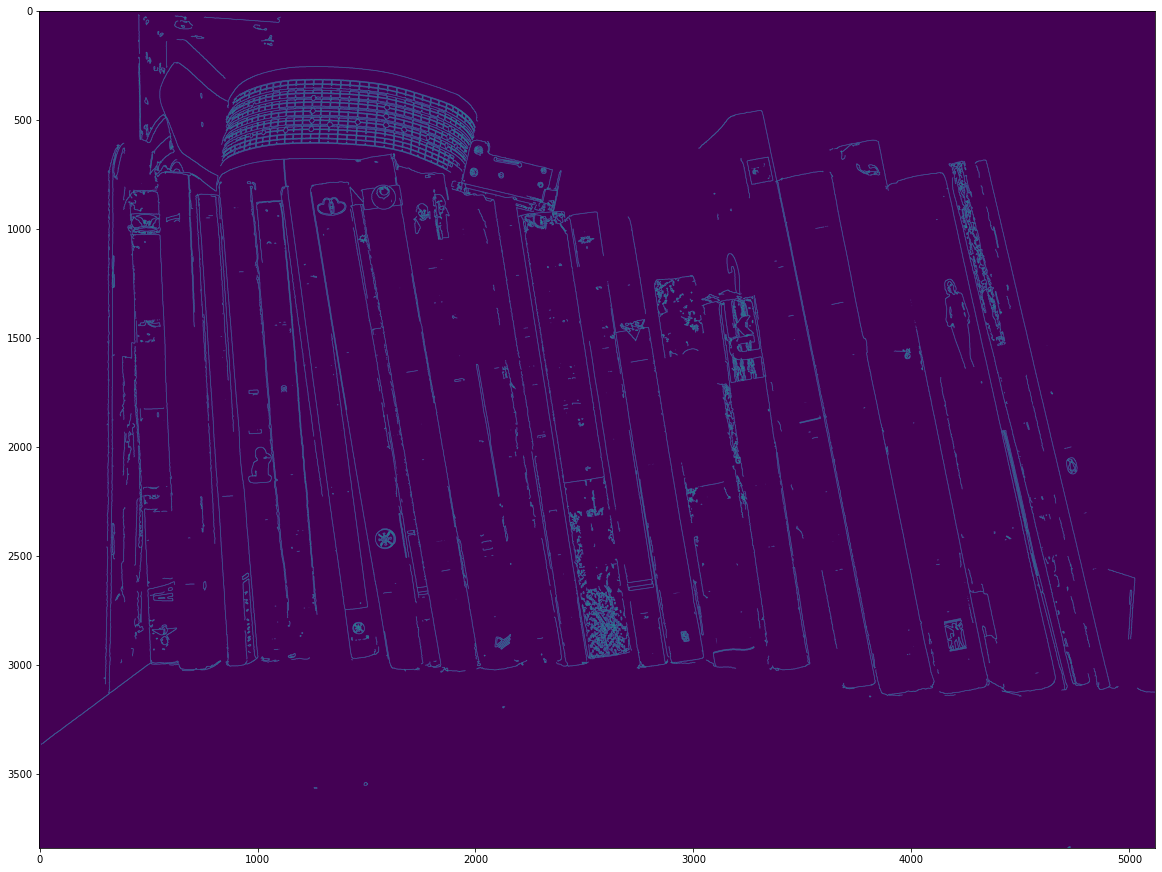

In [50]:
from google.cloud import vision

vision_client = vision.ImageAnnotatorClient()

def ocr_url(url):
    image = vision.Image()
    image.source.image_uri = url

    return vision_client.document_text_detection(image=image)

user = '0000000000000000000000000000'
shelf = '0000000000033'

image_blob = bucket.blob('images/%s/%s.jpg' % (user, shelf))

response = ocr_url('gs://biblosphere-210106.appspot.com/' + image_blob.name)


for p in response.full_text_annotation.pages:
    for b in p.blocks:
        words = set()
        for par in b.paragraphs:
            for w in par.words:
                #for s in w.symbols:
                #    v = s.bounding_box.vertices
                v = w.bounding_box.vertices
                box = np.array([[[v[0].x, v[0].y], [v[1].x, v[1].y], [v[2].x, v[2].y], [v[3].x, v[3].y]]])
                #center = (box[0,0] + box[0,2]) // 2
                #box = np.int0(0.95 * (box - center) + center) 
                cv2.drawContours(canny, box, -1, 0, -1)

plt.figure(figsize = (20,20))
plt.imshow(canny)   

In [9]:
kernel = np.array([[-1],[1]], dtype=np.int8)
i1 = np.array([[1, 1 , 1], [0, 0 , 0], [1, 1 , 1]], dtype=np.uint8)

i1 = cv2.filter2D(i1, cv2.CV_32F, kernel)

print(i1)


[[ 1.  1.  1.]
 [-1. -1. -1.]
 [ 1.  1.  1.]]


In [21]:
i1 = np.array([[1, 1 , 1], [2, 5 , 0], [1, 1 , 1]], dtype=np.uint8)

i2 = i1 * 128.0

print(i2)

i2[i2>255] = 255

print(i2)

[[128. 128. 128.]
 [256. 640.   0.]
 [128. 128. 128.]]
[[128. 128. 128.]
 [255. 255.   0.]
 [128. 128. 128.]]
